In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from tqdm import tqdm

In [2]:
def add_gaussian_noise(image, dispersion):
    row, col = image.shape
    mean = 0.0
    sigma = np.sqrt(dispersion)
    gauss = np.array(image.shape)
    gauss = np.random.normal(mean, sigma, (row, col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype('uint8')

In [3]:
def printing(img, title):
    plt.figure(figsize=(30,30))
    plt.title(title)
    plt.imshow(img, cmap='gray')

In [4]:
def get_imgs_with_noise(img, dispersions):
    for d in dispersions:
        gauss = add_gaussian_noise(img, d)
        yield gauss

In [5]:
def match(descr1, descr2):
    return cv2.BFMatcher().match(descr1[1], descr2[1])

In [6]:
def euclidean_distance(point1, point2):
    return distance.euclidean(point1, point2)

In [7]:
def get_points_coordinate(matches, kps1, kps2):
    for m in matches:
        idx1 = m.queryIdx
        idx2 = m.trainIdx
        yield kps1[idx1].pt, kps2[idx2].pt

In [8]:
def get_kps_and_descr(method, img):
    kps = method.detect(img, None) #находит точки
    kps.sort(key=lambda x: x.response, reverse=True) # сортирует по силе
    kps = kps[:100] # и бнрнт первые сто
    descr = method.compute(img, kps) # для них рассчитываются дискрипторы
    return kps, descr

In [9]:
def get_brief_kps_and_descr(star, brief, img):
    kps = star.detect(img, None) #находит точки
    kps.sort(key=lambda x: x.response, reverse=True) # сортирует по силе
    kps = kps[:100] # и берет первые сто
    descr = brief.compute(img, kps) # для них рассчитываются дискрипторы
    return kps, descr

In [10]:
def get_harris_kps_and_descr(sift, harris, img):
    kps = harris.detect(img, None) #находит точки
    kps.sort(key=lambda x: x.response, reverse=True) # сортирует по силе
    kps = kps[:100] # и берет первые сто
    descr = sift.compute(img, kps) # для них рассчитываются дискрипторы
    return kps, descr

In [11]:
def kp_method(img, method):
    
    if method=='SIFT':
        methods_object = cv2.xfeatures2d.SIFT_create()
    
    if method=='SURF':
        methods_object = cv2.xfeatures2d.SURF_create()
    
    if method=='ORB':
        methods_object = cv2.ORB_create()
    
    if method=='BRIEF':
        star_object = cv2.xfeatures2d.StarDetector_create()
        brief_object = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        kps, descr = get_brief_kps_and_descr(star_object, brief_object, img)
        return kps, descr
    
    if method=='HARRIS':
        sift_object = cv2.xfeatures2d.SIFT_create()
        harris_object = cv2.xfeatures2d.HarrisLaplaceFeatureDetector_create()
        kps, descr = get_harris_kps_and_descr(sift_object, harris_object, img)
        return kps, descr
    
    kps, descr = get_kps_and_descr(methods_object, img)
    return kps, descr

In [12]:
def plotting(X, Y, method, descriptor):
    plt.figure()
    plt.title(' График для метода {m} и дискриптора {d}'.format(m=method, d=descriptor))
    plt.plot(Y, X)
    plt.ylabel('Критерий качества')
    plt.xlabel('Величина {m}'.format(m=method))
    plt.show()

In [13]:
def reserching(img, method, descriptor, treshold):
    kps_1, descr_1 = kp_method(img, descriptor) # для исходной картинки считаем точки и дескриптор
    history = []
    
    if method == 'noise':
        dispersions=[x*10 for x in range(1, 11)]
        for noisy in tqdm(get_imgs_with_noise(input_img, dispersions=dispersions)):
                                                                # идем по всем степеням зашумленности изображения
            kps_2, descr_2 = kp_method(noisy, method=descriptor) # рассчитываем контрольные точки и дескрипторы для каждого
            
            matches = match(descr_1, descr_2) # сопоставляем 
            good_points_counter = 0
            for point1, point2 in get_points_coordinate(matches, kps_1, kps_2):
                if euclidean_distance(point1, point2) < treshold:
                    good_points_counter += 1
            history.append(good_points_counter)
        return history, dispersions
    
    if method == 'compression':
        qualities = [x for x in range(5, 100, 10)]
        for quality in tqdm(qualities):
            cv2.imwrite('./jpegs/quality_{q}.jpg'.format(q=quality),input_img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
            jpeg_im = im_read('./jpegs/quality_{q}.jpg'.format(q=quality))
            
            kps_2, descr_2 = kp_method(jpeg_im, method=descriptor) # рассчитываем контрольные точки и дескрипторы для каждого
            
            matches = match(descr_1, descr_2) # сопоставляем 
            good_points_counter = 0
            for point1, point2 in get_points_coordinate(matches, kps_1, kps_2):
                if euclidean_distance(point1, point2) < treshold:
                    good_points_counter += 1
            history.append(good_points_counter)
        return np.asarray(history)/100, qualities
    
    if method == 'resize':
        divisors = [x for x in range(1, 17, 1)]
        for divisor in tqdm(divisors):
            res_im = cv2.resize(img,None,fx=1/divisor, fy=1/divisor, interpolation = cv2.INTER_CUBIC)
            
            kps_2, descr_2 = kp_method(res_im, method=descriptor) # рассчитываем контрольные точки и дескрипторы для каждого
            matches = match(descr_1, descr_2) # сопоставляем 
            good_points_counter = 0
            for point1, point2 in get_points_coordinate(matches, kps_1, kps_2):
                point2 = (point2[0]*divisor, point2[1]*divisor)
                if euclidean_distance(point1, point2) < treshold:
                    good_points_counter += 1
            history.append(good_points_counter)
        return np.asarray(history)/100, divisors
    
    if method == 'rotation':
        rotations = [x for x in range(0, 370, 15)]
        for rotation in tqdm(rotations):
            rows,cols = img.shape
            M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation,1)
            rotated_img = cv2.warpAffine(img,M,(cols,rows))
            
            kps_2, descr_2 = kp_method(rotated_img, method=descriptor) # рассчитываем контрольные точки и дескрипторы для каждого
            
            matches = match(descr_1, descr_2) # сопоставляем 
            good_points_counter = 0
            for point1, point2 in get_points_coordinate(matches, kps_1, kps_2):
                point2 = M.dot(np.array(point2 + (1,)))
                if euclidean_distance(point1, point2) < treshold:
                    good_points_counter += 1
            history.append(good_points_counter)
        return np.asarray(history)/100, rotations

In [14]:
def plotting_for_all_methodes(methods, descriptors, treshold):
    for method in methods:
        for descriptor in descriptors:
            history = reserching(input_img, method=method, descriptor=descriptor, treshold=treshold)
            plotting(history[0], history[1], method=method, descriptor=descriptor)

In [15]:
def im_read(fname):
    readed = cv2.imread(fname, 0)
    return readed

10it [01:54, 10.10s/it]


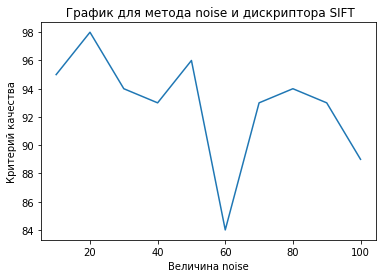

10it [00:26,  2.78s/it]


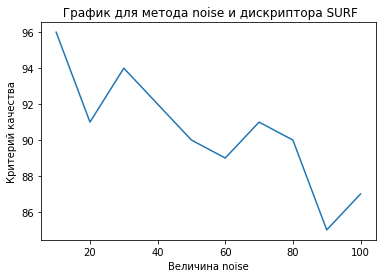

10it [00:10,  1.05s/it]


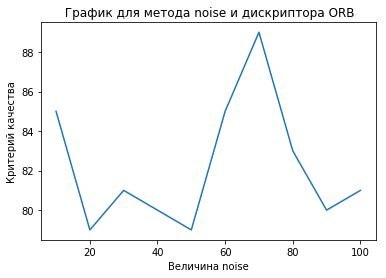

10it [00:36,  3.62s/it]


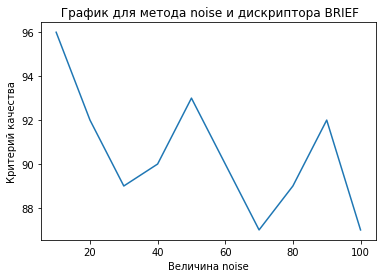

10it [03:20, 20.11s/it]


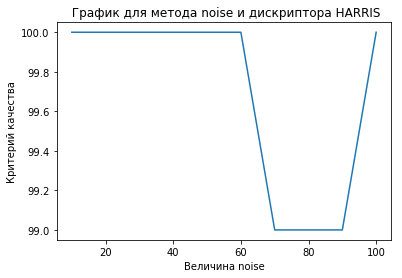

100%|██████████| 10/10 [01:12<00:00,  7.19s/it]


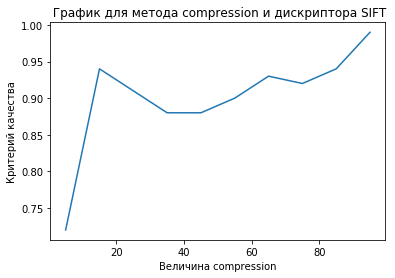

100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


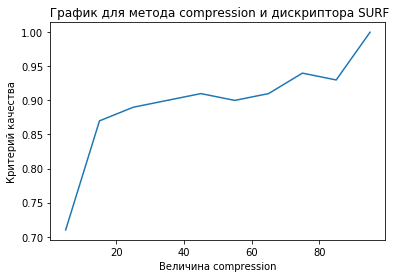

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


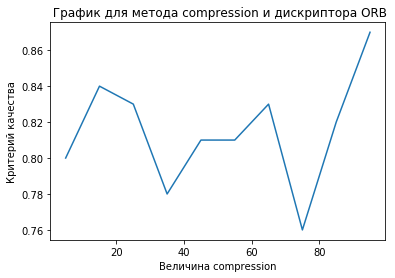

100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


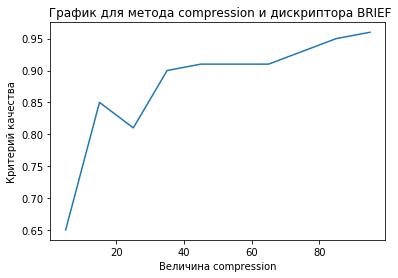

100%|██████████| 10/10 [03:09<00:00, 19.34s/it]


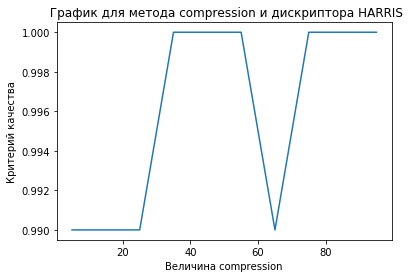

100%|██████████| 16/16 [00:10<00:00,  2.49it/s]


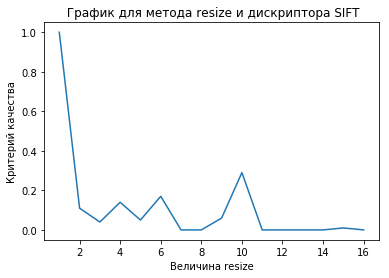

100%|██████████| 16/16 [34:11<00:00, 128.25s/it]  


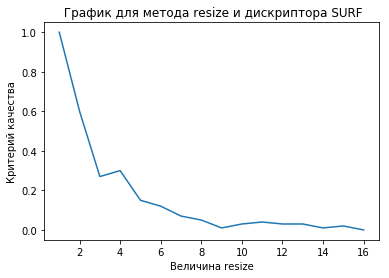

100%|██████████| 16/16 [00:00<00:00, 24.71it/s]


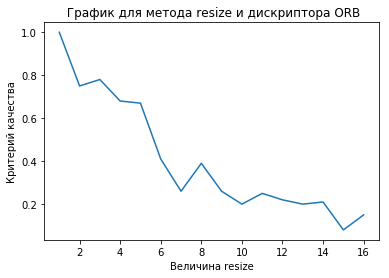

100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


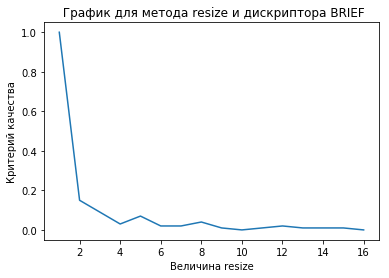

100%|██████████| 16/16 [00:33<00:00,  2.11s/it]


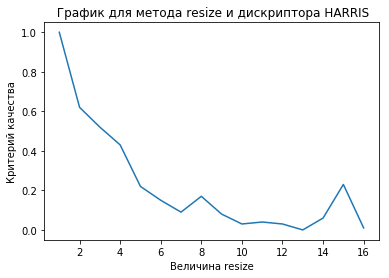

100%|██████████| 25/25 [03:32<00:00,  7.97s/it]


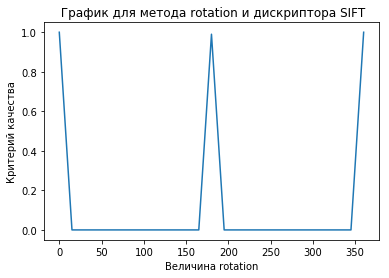

100%|██████████| 25/25 [00:48<00:00,  2.12s/it]


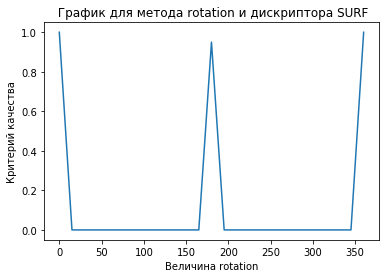

100%|██████████| 25/25 [00:07<00:00,  3.64it/s]


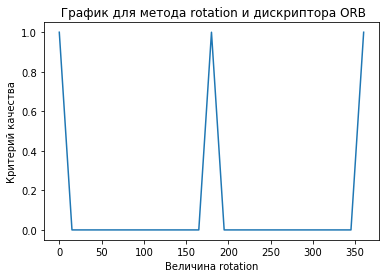

100%|██████████| 25/25 [01:24<00:00,  3.22s/it]


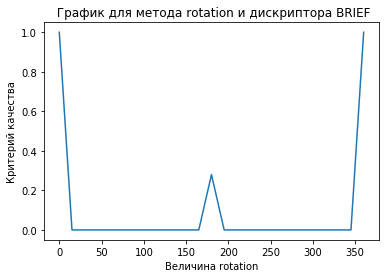

100%|██████████| 25/25 [08:18<00:00, 20.96s/it]


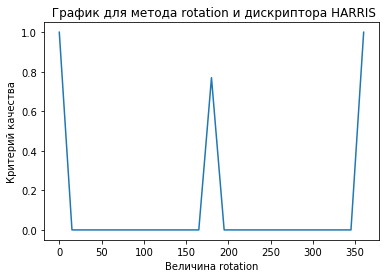

In [16]:
input_img = im_read('sw.jpg')
treshold = 100
methods = ['noise', 'compression', 'resize', 'rotation']
descriptors = ['SIFT', 'SURF', 'ORB', 'BRIEF', 'HARRIS']
plotting_for_all_methodes(methods=methods, descriptors=descriptors, treshold=treshold)